In [104]:
import torch
import sys
sys.path.append('../')
from DataType.ElectricField import ElectricField
from LightSource.Gaussian_beam import Guassian_beam
from Props.ASM_Prop import ASM_prop
from Props.RSC_Prop import RSC_prop
from Components.Thin_Lens import Thin_LensElement
from Components.Aperture import ApertureElement
from Components.QuantizedDOE import SoftGumbelQuantizedDOELayerv3 as SoftGumbelQuantizedDOELayer
from Components.QuantizedDOE import NaiveGumbelQuantizedDOELayer
from Components.QuantizedDOE import PSQuantizedDOELayer
from Components.QuantizedDOE import STEQuantizedDOELayer
from Components.QuantizedDOE import FullPrecisionDOELayer
from utils.Helper_Functions import normalize, DOE_xyz_cordinates_Generator
from utils.units import *
import numpy as np
import scipy.io
import time
import torch.nn as nn

from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 1. 2x2 Beam splitter

In [105]:
# Hologram parameters (high-temp resin)
epsilon = 2.52
tand = 0.0005
    
input_field_shape = [100, 100]
input_dxy = 1 * mm
doe_shape = [50, 50]
doe_dxy = 2 * mm
    
    
c0 = 2.998e8
f2 = 300e9  # 0.3 THz

wavelengths = c0 / f2
#print("The number of wavelengths: " +  str(wavelengths.shape[0]))

# all parameters of DOE optimization
doe_params = {
    'doe_size': doe_shape,
    'doe_dxy' : doe_dxy,
    'doe_level': 4,
    'look_up_table': None,
    'num_unit': 2,
    'height_constraint_max': 1 * mm,
    'tolerance': 0 * um,  
    'material': [epsilon, tand]
}

optim_params = {
    'c_s': 100,   # a number to boost the score (higher more robust to gumbel noise)
    'tau_max': 2.5, # maximum value of tau
    'tau_min': 1.5  # minimum value of tau
}

In [106]:
def define_FoM(resolution, sampling_size, wavelength, focal_length, position):
    """
    Calculates the Full-width-at-half-maximum (FWHM) by the far-field diffraction limit
    and applies it to model the point spread function (PSF) as a Gaussian function, with consistent intensity across positions.
    
    Parameters:
        resolution (tuple): The resolution of the field in pixels (height, width).
        sampling_size (float): The physical size of each pixel, in meters.
        wavelength (float): The wavelength of the light, in meters.
        focal_length (float): The focal length of the optical system, in meters.
        position (tuple): The target position in the field, in meters (x, y).
        
    Returns:
        torch.Tensor: The calculated and normalized PSF as a 2D Gaussian function over the specified field.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    height, width = resolution
    Length_x = sampling_size * width
    Length_y = sampling_size * height
    
    effective_L = torch.sqrt(torch.tensor((Length_x ** 2 + Length_y ** 2), device=device))
    NA = torch.sin(torch.atan(effective_L / (2 * focal_length)))
    FWHM = wavelength / (2 * NA)
    
    x_grid, y_grid = torch.meshgrid(torch.linspace(-Length_x / 2, Length_x / 2, steps=width, device=device),
                                    torch.linspace(-Length_y / 2, Length_y / 2, steps=height, device=device))
    
    x_position, y_position = torch.tensor(position, device=device)
    
    # Calculate the Gaussian PSF
    PSF = torch.exp(-((x_grid - x_position) ** 2 + (y_grid - y_position) ** 2) / ((FWHM*2) ** 2))
    
    # Normalize the PSF such that its maximum value is 1
    
    return normalize(PSF.unsqueeze(0).unsqueeze(0))

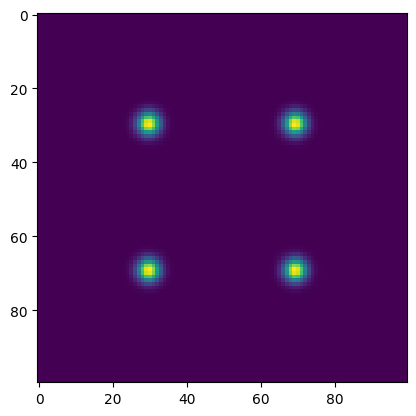

In [107]:
PSF_1 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[-20*mm, -20*mm])

PSF_2 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[20*mm, 20*mm])

PSF_3 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[-20*mm, 20*mm])

PSF_4 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[20*mm, -20*mm])

target = PSF_1 + PSF_2 + PSF_3 + PSF_4 #+ PSF_5 + PSF_6 + PSF_7 + PSF_8 + PSF_9
plt.imshow(target[0, 0, :, :].cpu())

In [115]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        #self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
        #                    bandlimit_type='exact', 
        #                    padding_scale=2, 
        #                    bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.1)
        
        self.input_field = self.field_before_DOE()

        self.doe = SoftGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        
        
        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [116]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [117]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []

optimizer = torch.optim.Adam(setup.parameters(), lr=0.015)
setup.cuda()
target = target.cuda()
photometric_loss_fn = nn.MSELoss()

best_loss = 10

out_amp_list = []
itrs_list = []
doe_list = []

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    #itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths)
        out_amp_list.append(out_amp.squeeze().cpu().detach().numpy())
        itr_list.append(itr)
        doe_list.append(setup.doe.height_map.cpu().detach().numpy())
    
    if loss < best_loss and itr > max_itrs * 0.8:
        best_setup = setup
        best_loss = loss
        best_field = out_field

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.052784886211156845
The iteration : 200, Loss: 0.0048362500965595245
The iteration : 400, Loss: 0.0024938974529504776
The iteration : 600, Loss: 0.0012659892672672868
The iteration : 800, Loss: 0.0006423731683753431
The iteration : 1000, Loss: 0.0004513667372521013
The iteration : 1200, Loss: 0.0003473675169516355
The iteration : 1400, Loss: 0.0002801197406370193
The iteration : 1600, Loss: 0.00023393768060486764
The iteration : 1800, Loss: 0.0002024201094172895
The iteration : 2000, Loss: 0.00019065623928327113
The iteration : 2200, Loss: 0.00017894667689688504
The iteration : 2400, Loss: 0.0001747274654917419
The iteration : 2600, Loss: 0.00017067429143935442
The iteration : 2800, Loss: 0.00017901684623211622
The iteration : 3000, Loss: 0.00017844665853772312
The iteration : 3200, Loss: 0.0001660151465330273
The iteration : 3400, Loss: 0.0001771115930750966
The iteration : 360

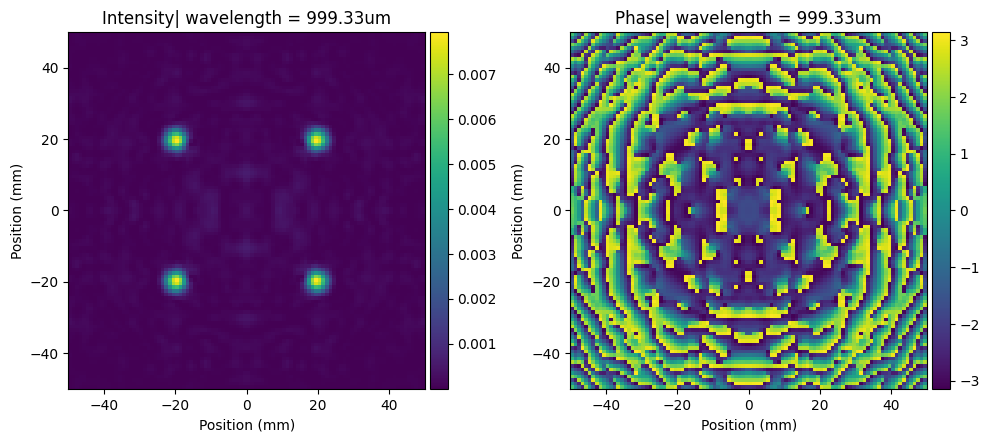

In [118]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

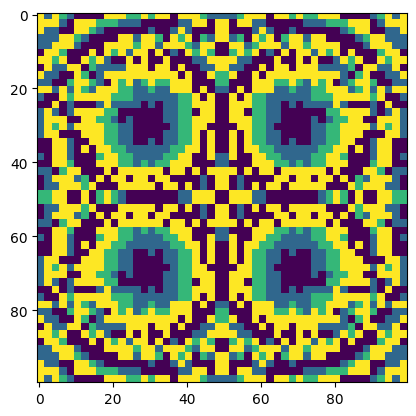

In [119]:
plt.imshow(best_setup.doe._height_map_.cpu().detach().numpy())

In [120]:
best_setup.doe.height_map.unique() / mm

tensor([0.0000, 0.2500, 0.5000, 0.7500], device='cuda:0',
       grad_fn=<DivBackward0>)

In [121]:
len(itr_list)

31

Animation saved successfully.


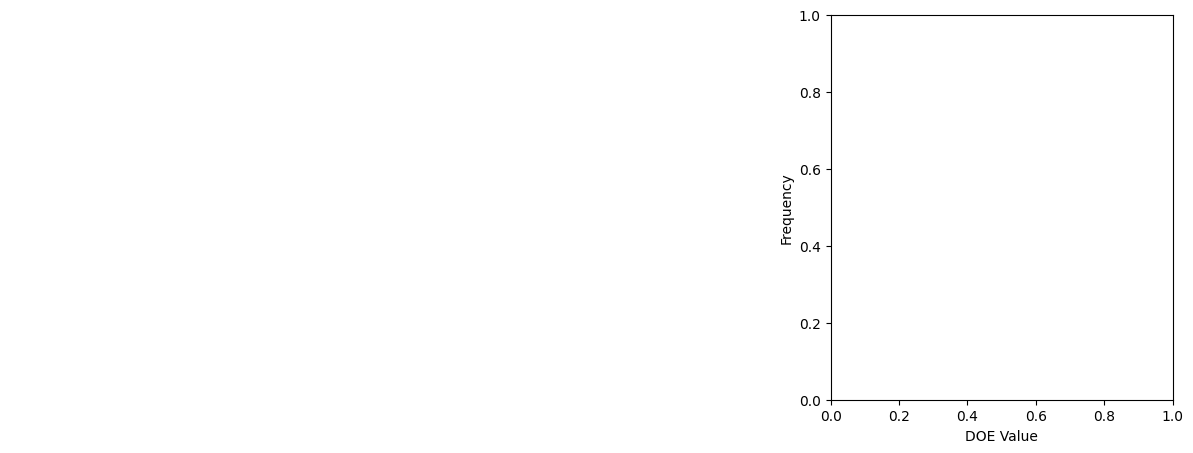

In [122]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Create new figure for GIF
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Turn off axes for the image plots
ax.axis('off')
ax2.axis('off')

# Initialization function: clear the content of the axes
def init():
    ax.clear()
    ax2.clear()
    ax3.clear()
    ax.axis('off')
    ax2.axis('off')
    ax3.set_xlabel('DOE Value')
    ax3.set_ylabel('Frequency')

# Animation function: update the plots
def animate(i):
    ax.clear()
    ax2.clear()
    ax3.clear()
    ax.axis('off')
    ax2.axis('off')
    
    # Update DOE and output field
    ax.imshow(doe_list[i])
    ax2.imshow(out_amp_list[i])
    
    # Update histogram
    hist_values = doe_list[i].flatten() / um
    ax3.hist(hist_values, bins=20, color='blue', alpha=0.7)
    ax3.set_title(f'Iteration {itr_list[i]}: DOE Value Distribution')
    ax3.set_xlabel('DOE Value (um)')
    ax3.set_ylabel('Frequency')
    
    # Update titles
    ax.set_title(f'Iteration {itr_list[i]}: DOE height map')
    ax2.set_title(f'Iteration {itr_list[i]}: Output Field')

# Create the animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(itr_list), interval=200, blit=False)

# Save the animation as a GIF
ani.save('optimization_evolution.gif', writer='pillow')
print("Animation saved successfully.")

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.9 -m pip install --upgrade pip


# 2. Dual Plane Hologram

In [123]:
# Hologram parameters (high-temp resin)
epsilon = 2.52
tand = 0.0005
    
input_field_shape = [100, 100]
input_dxy = 1 * mm
doe_shape = [100, 100]
doe_dxy = 2 * mm
    
    
c0 = 2.998e8
f2 = 300e9  # 0.3 THz

wavelengths = c0 / f2
#print("The number of wavelengths: " +  str(wavelengths.shape[0]))

# all parameters of DOE optimization
doe_params = {
    'doe_size': doe_shape,
    'doe_dxy' : doe_dxy,
    'doe_level': 4,
    'look_up_table': None,
    'num_unit': None,
    'height_constraint_max': 1 * mm,
    'tolerance': 0 * um,  
    'material': [epsilon, tand]
}

optim_params = {
    'c_s': 100,   # a number to boost the score (higher more robust to gumbel noise)
    'tau_max': 2.5, # maximum value of tau
    'tau_min': 1.5  # minimum value of tau
}

torch.Size([1, 1, 345, 454])


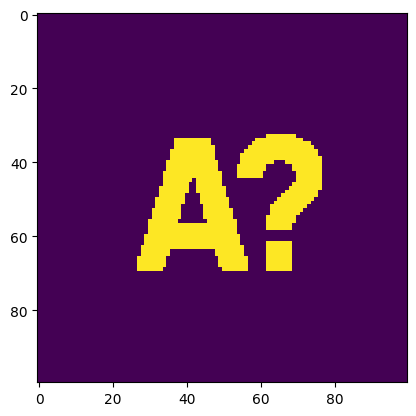

In [124]:
import numpy as np
from PIL import Image
from utils.Helper_Functions import normalize
import matplotlib.pyplot as plt
import torch.nn.functional as F
# choose the recon amp 
im = np.array(Image.open('./data/Aalto-logo.png').convert('L'))
target1 = torch.tensor(im, dtype=torch.float).unsqueeze(0).unsqueeze(0)
target1 = normalize(target1)
print(target1.shape)
target1 = F.pad(input=target1, pad=(140, 140, 140, 140), mode='constant', value=0)
target1 = nn.functional.interpolate(torch.round(target1), size=[100, 100])
plt.imshow(target1[0,0,:,:])

torch.Size([1, 1, 200, 200])


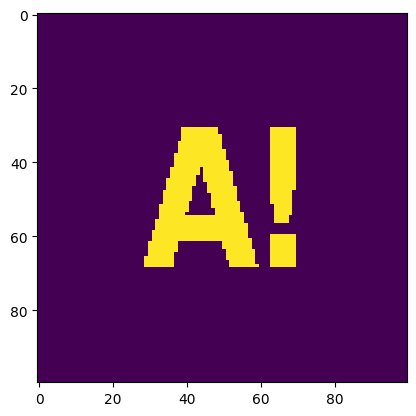

In [125]:
# choose the recon amp 
im = np.array(Image.open('./data/Aalto-logo2.png').convert('L'))
target2 = torch.tensor(im, dtype=torch.float).unsqueeze(0).unsqueeze(0)
target2 = normalize(target2)
print(target2.shape)
target2 = F.pad(input=target2, pad=(90, 90, 90, 90), mode='constant', value=0)
target2 = nn.functional.interpolate(torch.round(target2), size=[100, 100])
plt.imshow(target2[0,0,:,:])

In [126]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source  = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        #self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
        #                    bandlimit_type='exact', 
        #                    padding_scale=2, 
        #                    bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.05)
        
        self.input_field = self.field_before_DOE()

        self.doe = SoftGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=100 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [127]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [128]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
target2 = target2.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.02)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4000, gamma=0.1)
photometric_loss_fn = nn.MSELoss()

best_loss = 10

out_amp_list_1 = []
out_amp_list_2 = []
doe_list = []

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_1, target1) + photometric_loss_fn(out_amp_2, target2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    #itr_list.append(itr)
    #scheduler.step()
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    if itr % 200 == 0 or itr == (max_itrs-1):
        out_amp_list_1.append(out_amp_1.squeeze().cpu().detach().numpy())
        out_amp_list_2.append(out_amp_2.squeeze().cpu().detach().numpy())
        itr_list.append(itr)
        thickness = setup.doe.height_map.cpu().detach().numpy()
        H,W = thickness.shape
        crop_size = [50, 50]
        crop_height_front = int(round(H - crop_size[0]) / 2.0)
        crop_width_front = int(round(W - crop_size[1]) / 2.0)
    
        thickness = thickness[crop_height_front: crop_height_front + crop_size[0], crop_width_front: crop_width_front + crop_size[1]]
    
        doe_list.append(thickness)
    
    if loss < best_loss:
        best_setup = setup
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2


The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.11256444454193115
The iteration : 200, Loss: 0.03856600075960159
The iteration : 400, Loss: 0.0326504111289978
The iteration : 600, Loss: 0.030231526121497154
The iteration : 800, Loss: 0.028903618454933167
The iteration : 1000, Loss: 0.02794462814927101
The iteration : 1200, Loss: 0.027258744463324547
The iteration : 1400, Loss: 0.026786314323544502
The iteration : 1600, Loss: 0.026513177901506424
The iteration : 1800, Loss: 0.026146456599235535
The iteration : 2000, Loss: 0.027086295187473297
The iteration : 2200, Loss: 0.02757648378610611
The iteration : 2400, Loss: 0.02843792922794819
The iteration : 2600, Loss: 0.029754895716905594
The iteration : 2800, Loss: 0.030758503824472427
The iteration : 3000, Loss: 0.03149501234292984
The iteration : 3200, Loss: 0.033995531499385834
The iteration : 

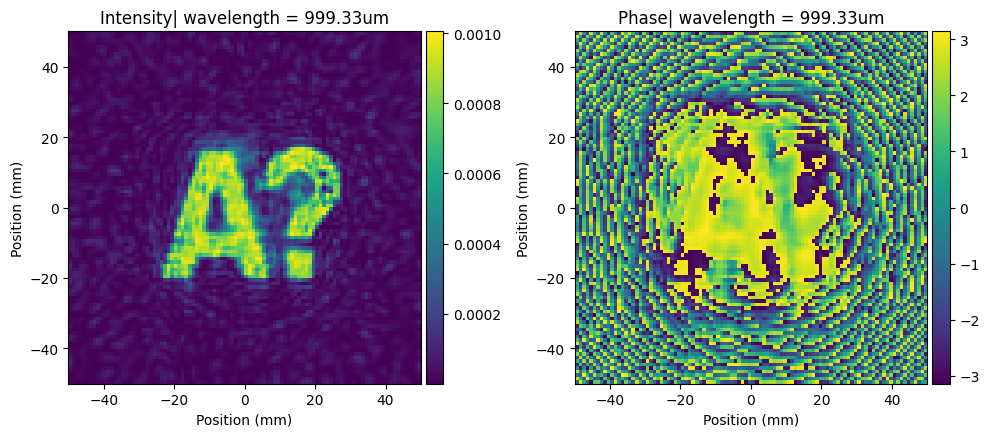

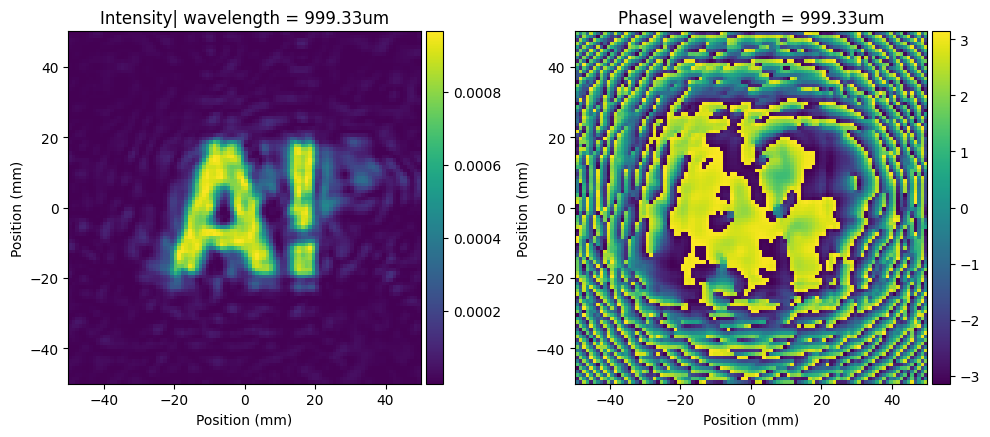

In [129]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

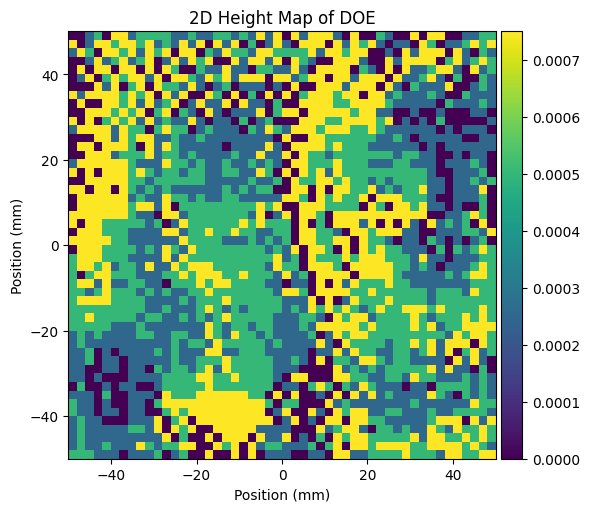

In [132]:
best_setup.doe.visualize(figsize=(6,6), crop_size=[50, 50])

Animation saved successfully.


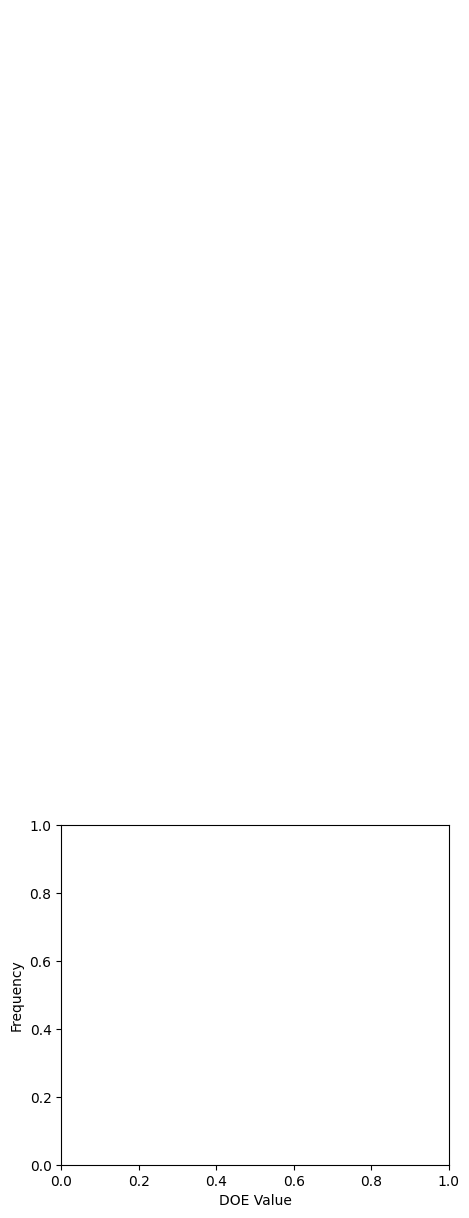

In [135]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Create new figure for GIF with three subplots
fig, (ax, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 15))

# Turn off axes for the image plots
ax.axis('off')
ax2.axis('off')

# Initialization function: clear the content of the axes
def init():
    ax.clear()
    ax2.clear()
    ax3.clear()
    ax.axis('off')
    ax2.axis('off')
    ax3.set_xlabel('DOE Value')
    ax3.set_ylabel('Frequency')

# Animation function: update the plots
def animate(i):
    ax.clear()
    ax2.clear()
    ax3.clear()
    ax.axis('off')
    ax2.axis('off')
    
    # Update DOE and output field
    ax.imshow(doe_list[i])
    ax2.imshow(out_amp_list_2[i])
    
    # Update histogram
    hist_values = doe_list[i].flatten() / um
    ax3.hist(hist_values, bins=20, color='blue', alpha=0.7)
    ax3.set_title(f'Iteration {itr_list[i]}: DOE Value Distribution')
    ax3.set_xlabel('DOE Value ($\mu$m)')
    ax3.set_ylabel('Frequency')
    
    # Update titles
    ax.set_title(f'Iteration {itr_list[i]}: DOE height map', fontsize=12, loc='center')
    ax2.set_title(f'Iteration {itr_list[i]}: Output Field', fontsize=12, loc='center')

# Create the animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(itr_list), interval=200, blit=False)

# Save the animation as a GIF
ani.save('optimization_evolution.gif', writer='pillow')
print("Animation saved successfully.")


# 3. Spatial frequency-division multiplexing

In [69]:
# Hologram parameters (high-temp resin)
epsilon = 2.52
tand = 0.0005
    
input_field_shape = [100, 100]
input_dxy = 1 * mm
doe_shape = [100, 100]
doe_dxy = 1 * mm
    
    
c0 = 2.998e8
f2 = 300e9  # 0.3 THz
f3 = 800e9  # 0.6 THz
fs = torch.arange(f2, f3, 100e9)
print(fs)
wavelengths = c0 / fs
print("The number of wavelengths: " +  str(wavelengths.shape[0]))

# all parameters of DOE optimization
doe_params = {
    'doe_size': doe_shape,
    'doe_dxy' : doe_dxy,
    'doe_level': 8,
    'look_up_table': None,
    'num_unit': None,
    'height_constraint_max': 1 * mm,
    'tolerance': 0 * um,  
    'material': [epsilon, tand]
}

optim_params = {
    'c_s': 400,   # a number to boost the score (higher more robust to gumbel noise)
    'tau_max': 5.5, # maximum value of tau
    'tau_min': 1.5  # minimum value of tau
}

tensor([3.0000e+11, 4.0000e+11, 5.0000e+11, 6.0000e+11, 7.0000e+11])
The number of wavelengths: 5


In [90]:
PSF_1 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths[0], focal_length=150*mm, position=[25*mm, -25*mm])

PSF_2 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths[0], focal_length=150*mm, position=[25*mm, 25*mm])

PSF_3 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths[0], focal_length=150*mm, position=[-25*mm, -25*mm])

PSF_4 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths[0], focal_length=150*mm, position=[-25*mm, 25*mm])

PSF_5 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths[0], focal_length=150*mm, position=[0*mm, 0*mm])

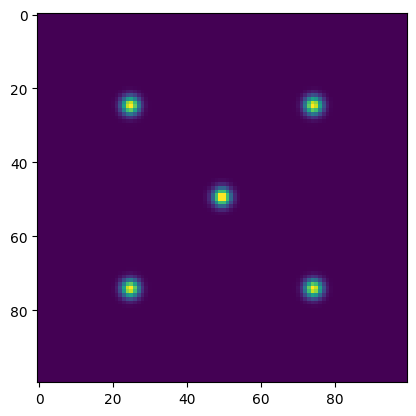

In [91]:
target = torch.concat([PSF_3, PSF_4, PSF_5, PSF_1, PSF_2], 1)
target.shape

target_vis = PSF_1 + PSF_2 + PSF_3 + PSF_4 + PSF_5
plt.imshow(target_vis[0, 0, :, :].cpu())

In [92]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=1.2 * mm,
                                    beam_waist_y=1.2 * mm,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.25 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.25 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.1)
        
        self.input_field = self.field_before_DOE()

        self.doe = SoftGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        
        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [93]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=torch.tensor(wavelengths))

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [94]:
max_itrs = 8000

losses = []
itr_list = []
itr_to_save_plots = []

optimizer = torch.optim.AdamW(setup.parameters(), lr=0.02)
setup.cuda()
target = target.cuda()
photometric_loss_fn = nn.MSELoss()

best_loss = 10

out_amp_list = []
doe_list = []

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths)
        itr_list.append(itr)
        doe_list.append(setup.doe.height_map.cpu().detach().numpy())
        out_amp_list.append(out_amp.cpu().detach().numpy())
    
    if loss < best_loss and itr > max_itrs * 0.8:
        best_setup = setup
        best_loss = loss
        best_field = out_field

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.008293860591948032
The iteration : 200, Loss: 0.0009267522254958749
The iteration : 400, Loss: 0.0008992081857286394
The iteration : 600, Loss: 0.0007926279213279486
The iteration : 800, Loss: 0.0006350664771161973
The iteration : 1000, Loss: 0.000513749080710113
The iteration : 1200, Loss: 0.0004391875700093806
The iteration : 1400, Loss: 0.0003885295882355422
The iteration : 1600, Loss: 0.000351637921994552
The iteration : 1800, Loss: 0.00032331841066479683
The iteration : 2000, Loss: 0.00030055551906116307
The iteration : 2200, Loss: 0.00028274874784983695
The iteration : 2400, Loss: 0.00026780206826515496
The iteration : 2600, Loss: 0.0002712220011744648
The iteration : 2800, Loss: 0.0002773171872831881
The iteration : 3000, Loss: 0.000283984059933573
The iteration : 3200, Loss: 0.0002840479137375951
The iteration : 3400, Loss: 0.00028071535052731633
The iteration : 3600, L

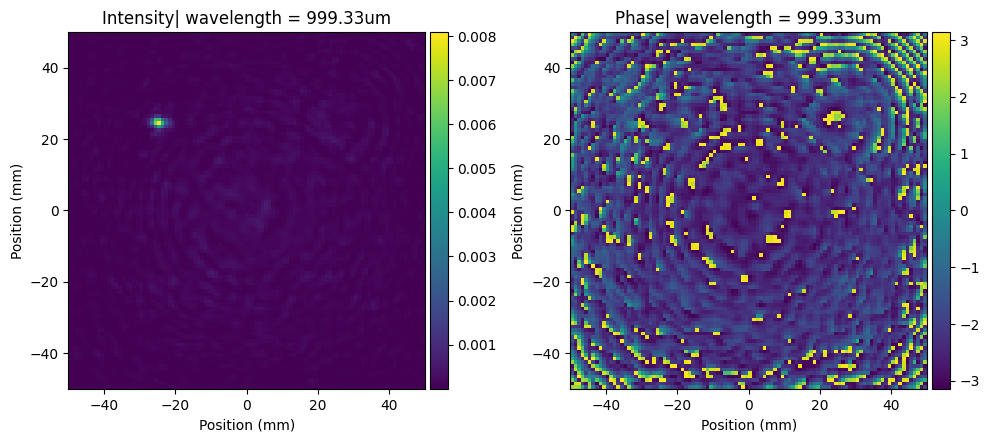

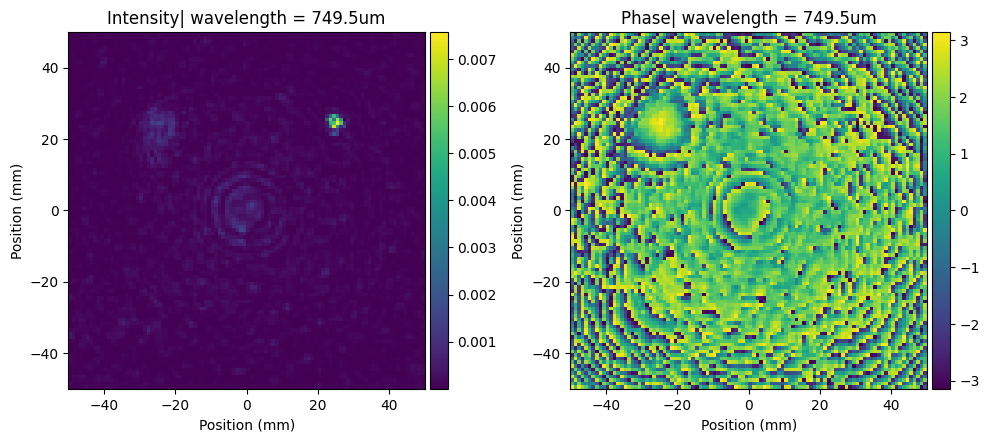

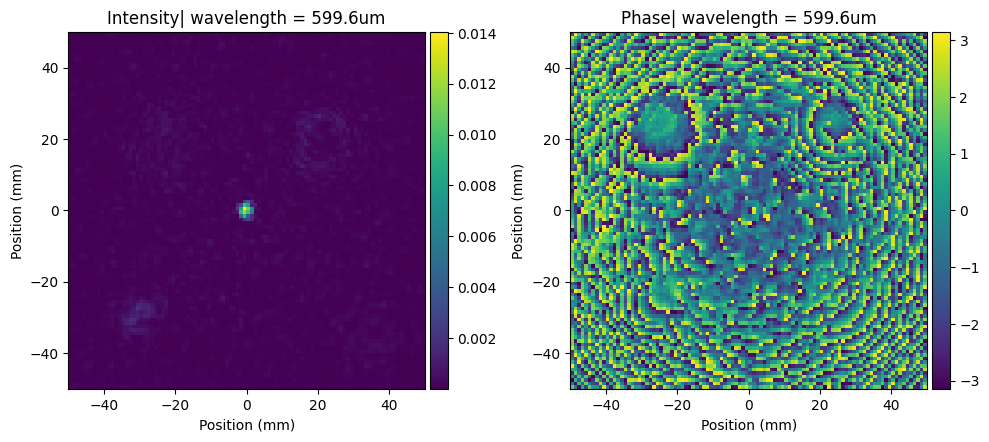

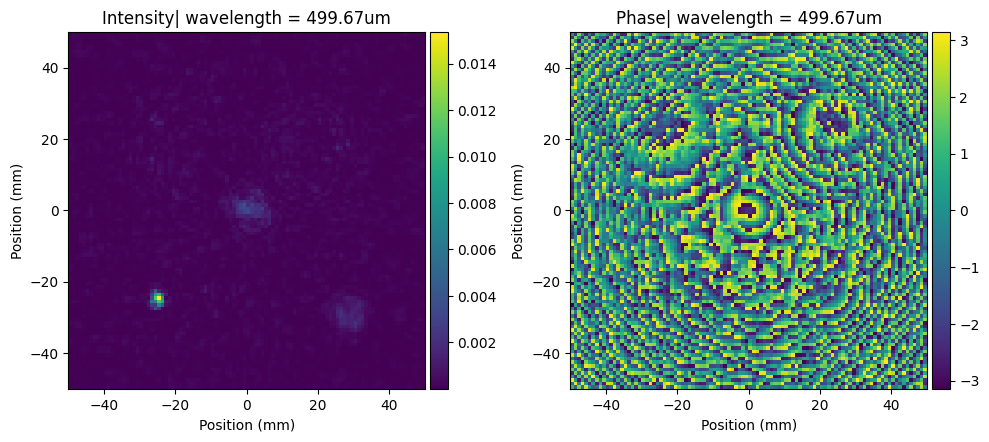

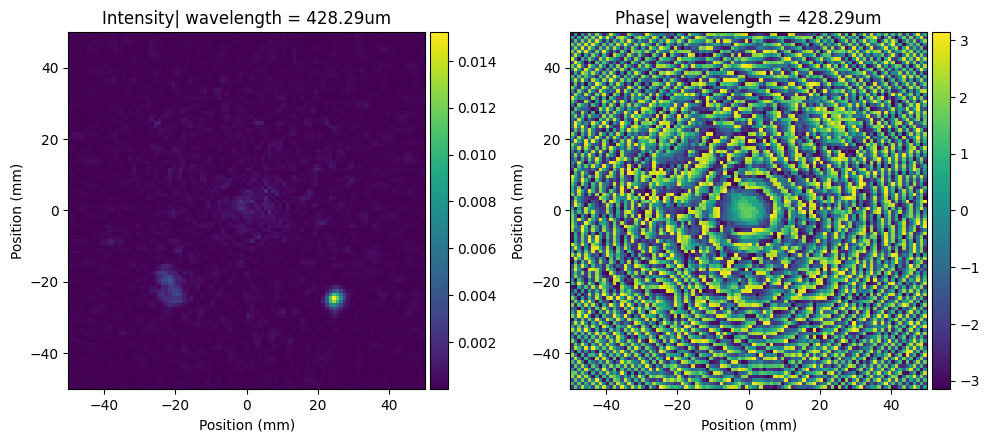

In [95]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[0], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[1], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[2], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[3], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[4], intensity=True)

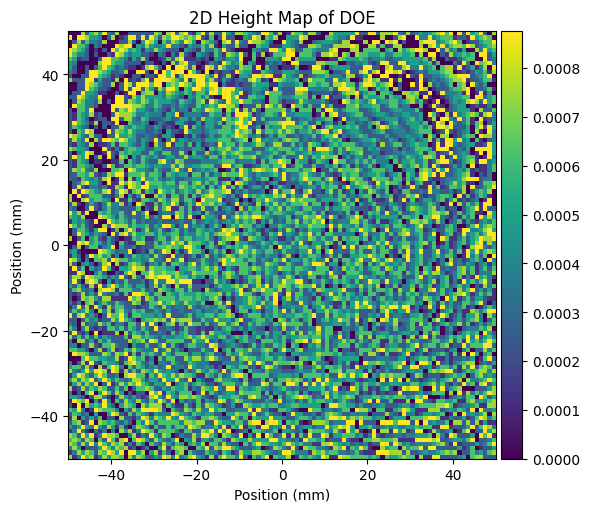

In [96]:
best_setup.doe.visualize(figsize=(6,6), crop_size=[100, 100])

In [97]:
best_setup.doe.height_map.unique() / um

tensor([  0.0000, 125.0000, 250.0000, 375.0000, 500.0000, 625.0001, 750.0000,
        875.0000], device='cuda:0', grad_fn=<DivBackward0>)

Animation saved successfully.


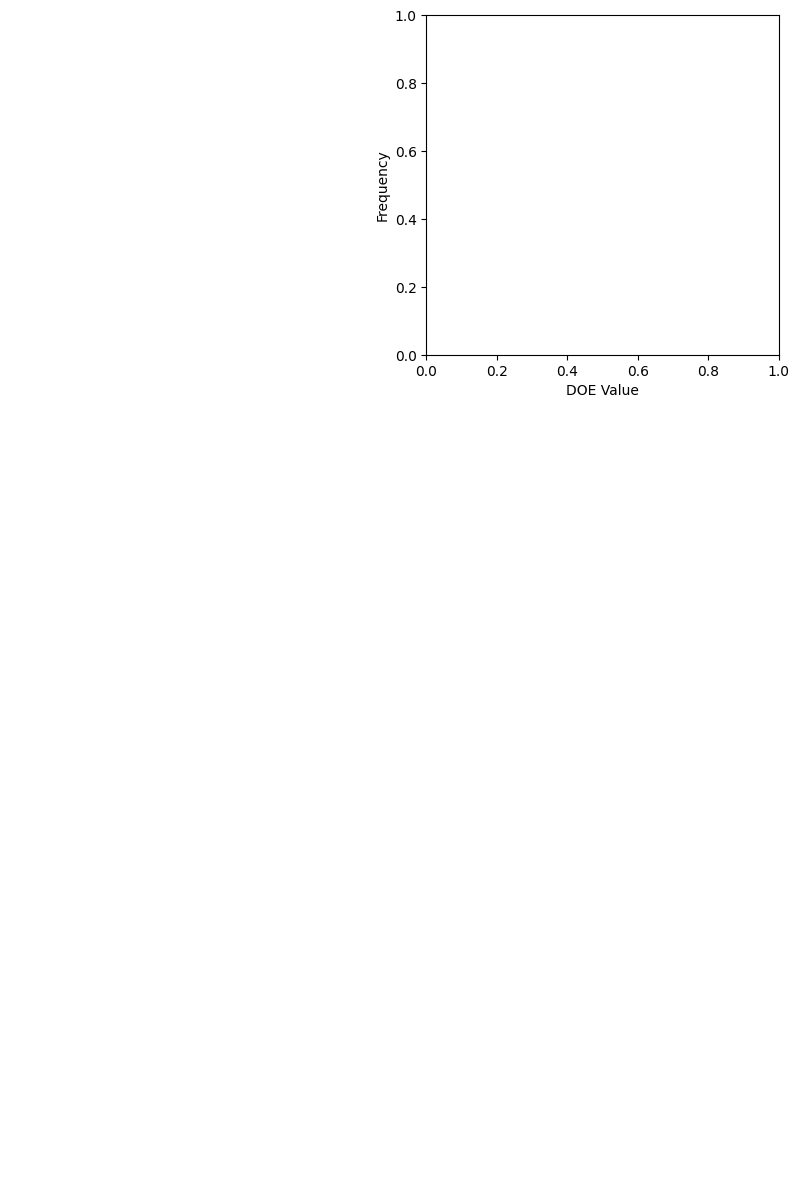

In [103]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Create new figure for GIF with six subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# Flatten the axes for easy access
(ax1, ax2, ax3, ax4, ax5, ax6) = axes.flatten()

# Turn off axes for the image plots
ax1.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')
ax6.axis('off')

# Initialization function: clear the content of the axes
def init():
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()
    
    ax1.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    ax5.axis('off')
    ax6.axis('off')
    
    ax2.set_xlabel('DOE Value')
    ax2.set_ylabel('Frequency')

# Animation function: update the plots
def animate(i):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()
    
    ax1.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    ax5.axis('off')
    ax6.axis('off')
    
    # Update DOE and histogram
    ax1.imshow(doe_list[i])
    hist_values = doe_list[i].flatten() / um
    ax2.hist(hist_values, bins=20, color='blue', alpha=0.7)
    ax2.set_title(f'Iteration {itr_list[i]}: DOE Value Distribution')
    ax2.set_xlabel('DOE Value ($\mu$m)')
    ax2.set_ylabel('Frequency')
    
    # Update four subplots from out_amp_list
    f = 0.3
    for j in range(4):
        axes_flat = [ax3, ax4, ax5, ax6]
        axes_flat[j].imshow(out_amp_list[i][0, j], cmap='viridis')
        axes_flat[j].set_title(f'Output Field f = {round(f+j*0.1, 1)} THz', fontsize=12, loc='center')

    # Update titles
    ax1.set_title(f'Iteration {itr_list[i]}: DOE height map', fontsize=12, loc='center')

# Create the animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(itr_list), interval=200, blit=False)

# Save the animation as a GIF
ani.save('optimization_evolution.gif', writer='pillow')
print("Animation saved successfully.")

In [101]:
x = round(5.76543, 1)
print(x)

5.8


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


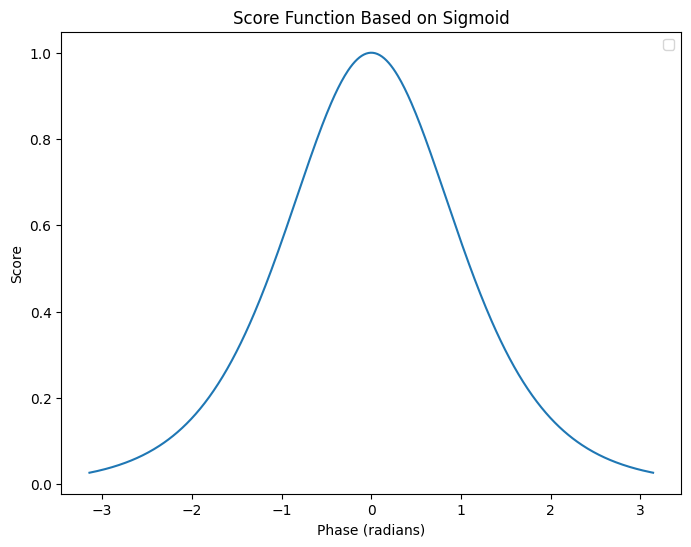

In [138]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def score_phase(phase, lut, s=5.0, func='sigmoid'):
    wrapped_phase = (phase + torch.pi) % (2 * torch.pi) - torch.pi
    lut = (lut[None, :, None, None] + torch.pi) % (2 * torch.pi) - torch.pi
    
    diff = wrapped_phase - lut
    diff = (diff + torch.pi) % (2 * torch.pi) - torch.pi  # signed angular difference
    diff /= torch.pi  # normalize
    
    if func == 'sigmoid':
        z = s * diff
        scores = torch.sigmoid(z) * (1 - torch.sigmoid(z)) * 4
    
    return scores.squeeze()

# Define a range of phase values and lookup table (lut) values
phase_values = torch.linspace(-torch.pi, torch.pi, 500)
lut_values = torch.tensor([0.0])  # Single value in LUT for simplicity

# Compute scores
scores = score_phase(phase_values, lut_values, s=5.0, func='sigmoid')

# Plotting the score function
plt.figure(figsize=(8, 6))
plt.plot(phase_values.numpy(), scores.numpy())
plt.xlabel('Phase (radians)')
plt.ylabel('Score')
plt.title('Score Function Based on Sigmoid')
plt.legend()
plt.grid(False)
plt.show()